In [ ]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('input.txt').read())
file_len = len(file)
print('file_len =', file_len)
all_characters += '—'
all_characters += '…'
all_characters

file_len = 1115394


'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c—…'

###Выбирает случайный отрывок из текста длины 200

In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ht of it; it must be
so: ever your fresh whore and your powdered bawd:
an unshunned consequence; it must be so. Art going
to prison, Pompey?

POMPEY:
Yes, faith, sir.

LUCIO:
Why, 'tis not amiss, Pompe


###RNN

##В ней важна только функция forward. Она принимает входной символ $x$, скрытое состояние $h$ и возвращает посчитанный вектор y и новое скрытое состояние h

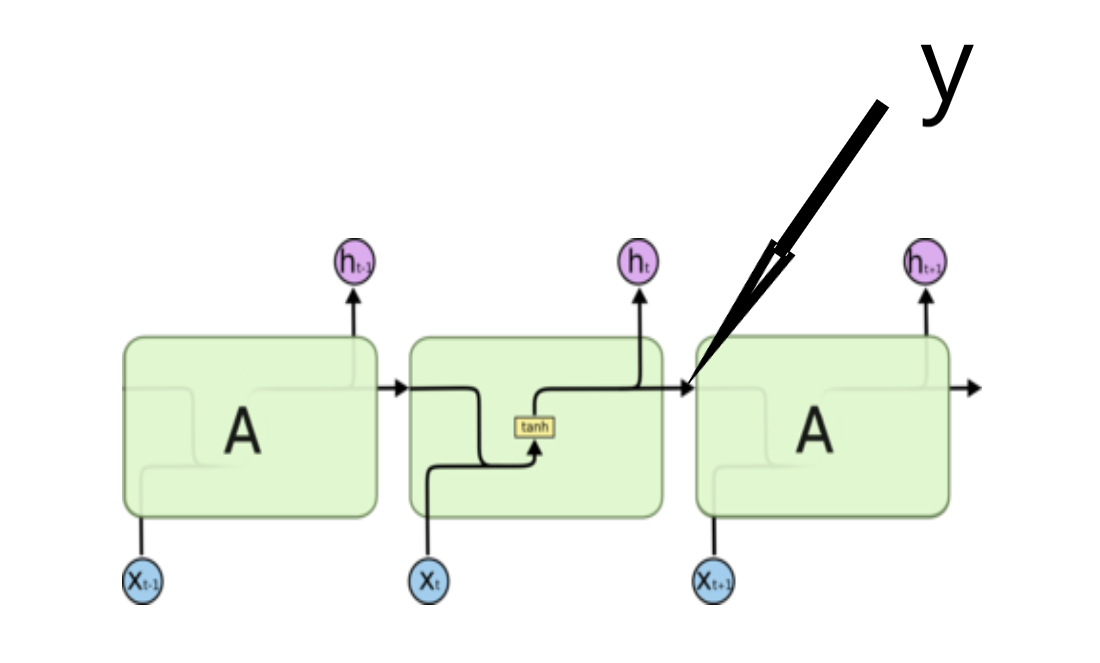

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)#кодирует входные символы во что-то, то есть преобразует символы в их эмбединги. Из размера input_size в hidden size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)#создаёт рекуррентный слой GRU, hidden_size размер входного и выходного скрытого слоя
        self.decoder = nn.Linear(hidden_size, output_size)#считает Wx + b --> приводит к output_size вектору, который потом пихнут в softmax

    def forward(self, input, hidden):####################################################  выводит y и h, размера hidden
        input = self.encoder(input.view(1, -1))#записывает в input эмбеды символов
        output, hidden = self.gru(input.view(1, 1, -1), hidden)#считает новые x и h
        output = self.decoder(output.view(1, -1))#преобразует в вектор размерности output
        return output, hidden #выводит y,h

    def init_hidden(self):#инициализирует скрытое состояние нулями
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))



##Преобразовывает символы в их код в таблице all_characters

In [ ]:
# Turn string into list of longs
def char_tensor(string):# преобразует исходный тензор с символами в тензор с индексами этих символов
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])




##Возвращает символы с нулевого до предпоследнего - inp

##и с первого до последнего - target

In [ ]:
def random_training_set():#выводит индексы с 0 до -1 и с 1 до последнего
    chunk = random_chunk()# для нашего текста
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

##Принимает на вход строку символов, количество символов которые нужно предсказать, параметр, который чем меньше, тем меньше случайность при выборе символа после softmax, т.е будут чаще выбираться символы у которых вероятность в softmax больше всего

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):###################выводит всю последовательность вместе с
                                                                                #предсказанным символом
    hidden = decoder.init_hidden()# инициализируем скрытое состояние
    prime_input = char_tensor(prime_str)#преобразуем символы в их индексы       #на вход принимает строку символов на данных момент
    predicted = prime_str               #в таблице all_characters
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):                                         #посчитали h для каждого символа в последовательности
        _, hidden = decoder(prime_input[p], hidden)                             #кроме последнего
    inp = prime_input[-1]                                                       #в inp последний символ

    for p in range(predict_len):                                                #предсказывает predict_len следующих символов
        output, hidden = decoder(inp, hidden)                                   #имеем h, который прошёл через все предыдущие слои
                                                                                #для последнего слоя подаём последний символ и этот h
        # Sample from the network as a multinomial distribution                 #в output находится вектор y из которого пытаемся
        output_dist = output.data.view(-1).div(temperature).exp()#softmax       #вытащить самый вероятный символ
        top_i = torch.multinomial(output_dist, 1)[0]                            #top_i - индекс предсказанного символа

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]                                  #сам предсказанный символ
        predicted += predicted_char                                             #добавляем к последовательности предсказанный символ
        inp = char_tensor(predicted_char)                                       #далее подаём сформированную последовательность
                                                                                #для предсказания next символа на её основе
    return predicted                                                            #собственно сгенерированный текст

# Training

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

##инициализирует начальное значение скрытого состояния h, инициализирует градиент.

##Далее, используя Cross-Entropy (принимает выходное значение - y которое выдал блок RNN, далее с этим значением y и значением целевого символа считает loss) считает Loss и использует backprop

In [ ]:
import torch.nn.functional as F
def train(inp, target):
    hidden = decoder.init_hidden()                                              #создаём h0
    decoder.zero_grad()                                                         #инициализируем градиент
    loss = 0
    for c in range(chunk_len):                                                  #проходимся по всему тексту
        output, hidden = decoder(inp[c], hidden)                                #считаем выходные y,h
        loss += criterion(output, target[c].unsqueeze(0))                                    #

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
randomTrainSet = random_training_set()
inp_my = randomTrainSet[0]
target_my = randomTrainSet[1]

for epoch in range(1, n_epochs + 1):
    loss = train(inp_my, target_my)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 22s (100 5%) 0.0126]
Whene'er we come to our account.

Lieutenant:
Sir, I bechieve as soon
As draw his sword; yet he hath l 

 41s (200 10%) 0.0038]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
When 

 1s (300 15%) 0.0020]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
When 

 21s (400 20%) 0.0012]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
When 

 41s (500 25%) 0.0009]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
When 

 0s (600 30%) 0.0006]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
When 

 20s (700 35%) 0.0005]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
When 

 40s (800 40%) 0.0004]
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or

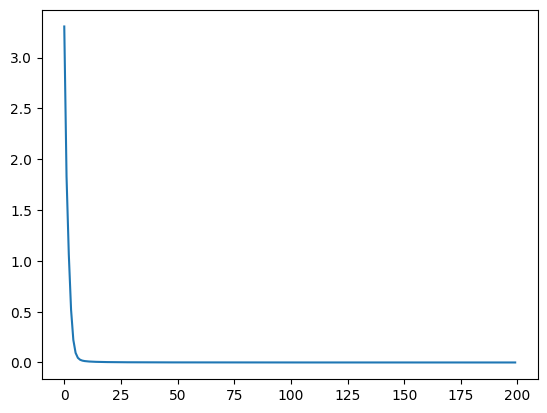

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [ ]:
print(evaluate('brother', 200, temperature=1))
print('\n------\n', evaluate('tell', 200, temperature=1))

brother we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
Whene'er we come to our account.

Lieutenant:
Sir, I beseech shall break his neck or hazard mine,
Whene'er we 

------
 tellmine,
Whene'er we come to our account.

Lieutenant:
Sir, I beseechieve as soon
As draw his sword; yet he hath left undone
That which shall break his neck or hazard mine,
Whene'er we come to our accoun


Lower temperatures are less varied, choosing only the more probable outputs:

In [ ]:
Borodino_text = '''— Tell me, Uncle, it's not for nothing
Moscow, burned down by fire,
Given to a Frenchman?
After all, there were fighting fights,
Yes, they say, some more!
No wonder the whole of Russia remembers
About Borodin's day!
— Yes, there were people in our time,
Not like the current tribe:
The heroes are not you!
They got a bad share:
Few returned from the field…
If it were not God's will,
They would not have given Moscow away!
We retreated in silence for a long time,
It was annoying, they were waiting for a fight,
The old men grumbled:
"What are we? for winter quarters?
Don't the commanders dare
Strangers tear up their uniforms
About Russian bayonets?"
And so they found a large field:
There is a place to roam in the wild!
A redoubt was built.
Our ears are on top of our heads!
A little morning lit up the guns
And the forests are blue tops —
The French are right there.
I hammered the charge into the gun tight
And I thought: I'll treat a friend!
Wait a minute, Brother musyu!
What's there to trick, perhaps to fight;
We're going to break down the wall.,
We'll stand with our heads
For your homeland!
We were in a shootout for two days.
What's the use of such a trifle?
We waited for the third day.
Speeches began to be heard everywhere:
"It's time to get to the buckshot!"
And here on the field of the terrible sich
A shadow fell at night.
I took a nap at the carriage,
And it was heard until dawn,
How the Frenchman rejoiced.
But our bivouac was quiet.:
Who cleaned the shako all beaten up,
Who sharpened the bayonet, grumbling angrily,
Biting his long mustache.
And only the sky lit up,
Everything is noisy and suddenly it's moving,
The formation flashed behind the formation.
Our colonel was born a grip:
A servant to the tsar, a father to the soldiers…
Yes, I feel sorry for him: smitten by bulat,
He sleeps in the damp ground.
And he said, flashing his eyes:
"Guys! Isn't Moscow following us?
Let's die near Moscow,
How our brothers died!"
And we promised to die,
And they kept their oath of allegiance
We are in the Battle of Borodino.
Well, it was a day! Through the flying smoke
The French moved like clouds,
And all to our redoubt.
Lancers with colorful badges,
Dragoons with horse tails,
Everything flashed before us,
Everyone has been here.
You will not see such battles!..
Banners flew like shadows,
The fire glittered in the smoke,
Bulat sounded, buckshot screamed,
The fighters' hand is tired of stabbing,
And it prevented the nuclei from flying by
A mountain of bloody bodies.
The enemy experienced a lot that day,
What does Russian combat mean?,
Our hand-to-hand fight!..
The earth was shaking — like our breasts,
Horses and people got mixed up in a bunch,
And the volleys of a thousand guns
They merged into a long - drawn - out howl…
It's getting dark. They were all ready
Start a new fight tomorrow
And stand to the end…
The drums began to crackle —
And the Busurmans retreated.
Then we began to count the wounds,
Count the comrades.
Yes, there were people in our time,
A mighty, dashing tribe:
The heroes are not you.
They got a bad share:
Few returned from the field.
If it wasn't God's will,
They would not have given Moscow away!'''

print(evaluate(Borodino_text, 200, temperature=0.5))

IndexError: index out of range in self

In [ ]:
print(evaluate('Frost and Sun is a wonderful day', 150, temperature=0.4))